# Exploratory data analysis

In [22]:
%load_ext autoreload
%autoreload 2
from im2gps.data.flickr_repo import FlickrPhoto
from im2gps.conf.config import load_config
from mongoengine import connect
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
cfg = load_config(['../config-local.yaml'])
connect(db=cfg.data.db.database, host=cfg.data.db.host, port=cfg.data.db.port)

MongoClient(host=['localhost:51998'], document_class=dict, tz_aware=False, connect=True, read_preference=Primary())

## Preparing data

First af all I downloaded shapefiles (from [here](https://geoportal.cuzk.cz/(S(f3gghnfoxhphfxzl05utvssm))/Default.aspx?lng=EN&mode=TextMeta&side=dsady_RUIAN&metadataID=CZ-CUZK-SH-V&mapid=5&menu=252)) for Czech Republic, which contain information about geographical shapes of different administartive units and than I cpnverted this file to GeoJson. Now I can use this information to query database for photos that lie in each region of ineterst.

In [15]:
import json
def open_file(path):
    with open(path,'r') as f:
        file = json.load(f)
    return file

## Number of photos per CZ region

Let's get information about number of photos for each region in CZ.

In [59]:
cz_kraj = open_file('/Users/zakharca/Documents/Study/thesis/src/resources/cz_kraj.json')
num_photos_per_region = {}
for feature in cz_kraj['features']:
    region_name = feature['properties']['NAZEV_NUTS']
    region_poly = feature['geometry']['coordinates'][0]
    count = FlickrPhoto.objects(geo__coords__geo_within_polygon=region_poly).count()
    num_photos_per_region[region_name] = count

num_photos_per_region

{'Hlavní město Praha': 133658,
 'Středočeský kraj': 146214,
 'Jihočeský kraj': 24564,
 'Plzeňský kraj': 7823,
 'Karlovarský kraj': 4353,
 'Ústecký kraj': 4832,
 'Liberecký kraj': 4241,
 'Královéhradecký kraj': 7031,
 'Pardubický kraj': 1984,
 'Kraj Vysočina': 3508,
 'Jihomoravský kraj': 11259,
 'Olomoucký kraj': 2897,
 'Moravskoslezský kraj': 3661,
 'Zlínský kraj': 2814}

Středočeský kraj is a special case, polygon for this region also contains polygon for Prague, so the number of photos above for Středočeský kraj is incorrect. Let's fix it.

In [63]:
prg_poly = cz_kraj['features'][0]['geometry']['coordinates'][0]
str_cz_poly = cz_kraj['features'][1]['geometry']['coordinates'][0]
num_photos_per_region['Středočeský kraj'] = FlickrPhoto.objects(geo__coords__geo_within={"type": "Polygon", "coordinates": [str_cz_poly, prg_poly]}).count()

In [64]:
num_photos_per_region

{'Hlavní město Praha': 133658,
 'Středočeský kraj': 12556,
 'Jihočeský kraj': 24564,
 'Plzeňský kraj': 7823,
 'Karlovarský kraj': 4353,
 'Ústecký kraj': 4832,
 'Liberecký kraj': 4241,
 'Královéhradecký kraj': 7031,
 'Pardubický kraj': 1984,
 'Kraj Vysočina': 3508,
 'Jihomoravský kraj': 11259,
 'Olomoucký kraj': 2897,
 'Moravskoslezský kraj': 3661,
 'Zlínský kraj': 2814}

Let's now add this information to the database for later use.

In [101]:
for feature in cz_kraj['features']:
    region_name = feature['properties']['NAZEV_NUTS']
    region_poly = feature['geometry']['coordinates'][0]
    print(region_name)
    if region_name == 'Středočeský kraj':
        photos = FlickrPhoto.objects(geo__coords__geo_within={"type": "Polygon", "coordinates": [str_cz_poly, prg_poly]})
    else:
        photos = FlickrPhoto.objects(geo__coords__geo_within_polygon=region_poly)
    for photo in photos:
        photo.geo.region = region_name
        photo.save()

Hlavní město Praha
Středočeský kraj
Jihočeský kraj
Plzeňský kraj
Karlovarský kraj
Ústecký kraj
Liberecký kraj
Královéhradecký kraj
Pardubický kraj
Kraj Vysočina
Jihomoravský kraj
Olomoucký kraj
Moravskoslezský kraj
Zlínský kraj


And save the results to CSV file.

In [ ]:
values = list(num_photos_per_region.values())
total_photos = sum(values)
num_photos_df = pd.DataFrame({'region': num_photos_per_region.keys(), 
                              'num_photos': values, 
                              'proportion': [num/total_photos for num in values]}).sort_values('num_photos')
num_photos_df.to_csv("/Users/zakharca/Documents/Study/thesis/src/output/photos_by_regions.csv")

## Number of photos per city district in Prague  

I also have a shapefile which contains geographical information about city districts. Since majority of photos in the dataset comes from Prague, let's find out number of photos per district in Prague.

In [125]:
cz_city_parts = open_file('/Users/zakharca/Documents/Study/thesis/src/resources/cz_mc.json')
n_photos_per_city_part = {}
for feature in cz_city_parts['features']:
    if feature['properties']['KOD_LAU1'] != 'CZ0100':
        continue
    citi_part_name = feature['properties']['NAZEV_MC']
    region_poly = feature['geometry']['coordinates'][0]
    count = FlickrPhoto.objects(geo__coords__geo_within_polygon=region_poly).count()
    n_photos_per_city_part[citi_part_name] = count

In [127]:
counts = list(n_photos_per_city_part.values())
total = sum(counts)
data = {
    'city-part': n_photos_per_city_part.keys(),
    'count': counts,
    'proportion': [n/total for n in counts]
}
city_parts_count_df = pd.DataFrame(data)
city_parts_count_df.to_csv('../output/photos_per_city_part.csv')

In [128]:
for feature in cz_city_parts['features']:
    if feature['properties']['KOD_LAU1'] != 'CZ0100':
        continue
    citi_part_name = feature['properties']['NAZEV_MC']
    region_poly = feature['geometry']['coordinates'][0]
    for photo in FlickrPhoto.objects(geo__coords__geo_within_polygon=region_poly):
        photo.geo.city_part = citi_part_name
        photo.save()

# Analysis and visualisation

## Distribution by regions

In [2]:
import seaborn as sns
import matplotlib.ticker as ticker

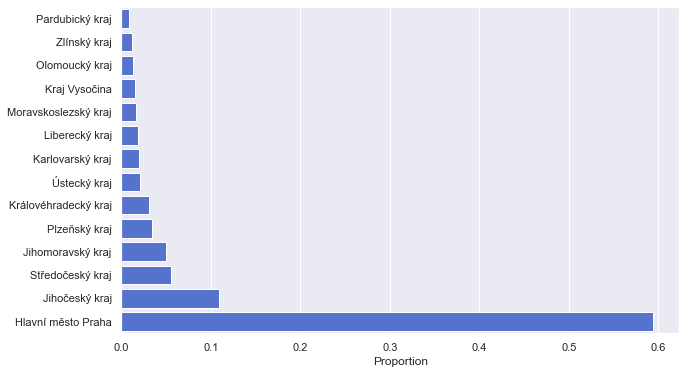

In [189]:
df = pd.read_csv("/Users/zakharca/Documents/Study/thesis/src/output/photos_by_regions.csv")
sns.set(rc={'figure.figsize':(10,6)})
g=sns.barplot(data=df, x='proportion',y='region', color='royalblue')
g.set(xlabel='Proportion', ylabel='');

## Distribution by Prague districts

Let's now see the distribution be city districts, all districts that have less than 1% of photos we will group into Other category

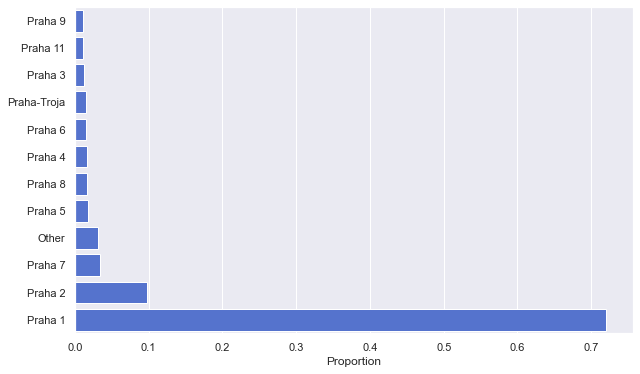

In [192]:
df = pd.read_csv("/Users/zakharca/Documents/Study/thesis/src/output/photos_per_city_part.csv")
df.loc[df['proportion']<0.01, 'city-part'] ='Other'
df=df.groupby('city-part').sum().reset_index().sort_values('proportion')
g=sns.barplot(data=df, x='proportion',y='city-part',color='royalblue')
g.set(xlabel='Proportion', ylabel='');

Note that percentages in the graph above correspond to percantage of all photos in **Prague**

## Distribution by authors

Let's also see how photos are distriburted by authors. 

In [179]:
pipeline = [{"$group": {"_id": '$owner_name', "count": {"$sum": 1}}},{"$sort": {"count":-1}}]

author_counts = [result for result in FlickrPhoto.objects().aggregate(pipeline)]

In [180]:
owners = []
counts = []
for ac in author_counts:
    owners.append(ac['_id'])
    counts.append(ac['count'])

num_photos = sum(counts)
author_counts_df = pd.DataFrame({'owner_name': owners, 'count': counts, 'proportion': [c/num_photos for c in counts]})

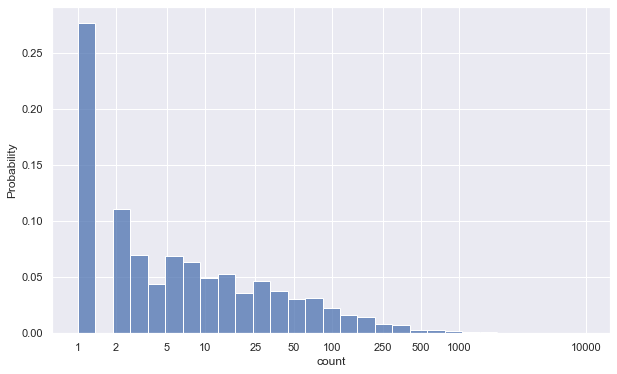

In [217]:
g=sns.histplot(data=author_counts_df, x='count', log_scale=10)
g.xaxis.set_major_formatter(ticker.ScalarFormatter())
g.axes.set_xticks([1,2,5,10,25,50,100,250,500,1000,10000]);

From the table above we can see that there is a total of 6409 authors in the database, 25% of them have only 1 photo (note that this doesn't mean that author have only one photo on Flickr, but that it has only one photo which has geo coordinates in Czech Republic), 50% have 4 or less photos, 75% of them have 20 or less photos and the maximum number of photos per author is 9744.

## Distribution by density

In [6]:
import glob
import os
path = r'../output/densities/'                   
all_files = glob.glob(os.path.join(path, "*.csv"))
df_from_each_file = (pd.read_csv(f) for f in all_files)
dens_df= pd.concat(df_from_each_file, ignore_index=True)

In [7]:
dens_df=dens_df.reset_index()
dens_long_df = pd.melt(dens_df, id_vars='photo_id', value_vars=['density_10m', 'density_100m', 'density_500m'], value_name='density', var_name='density_scale')

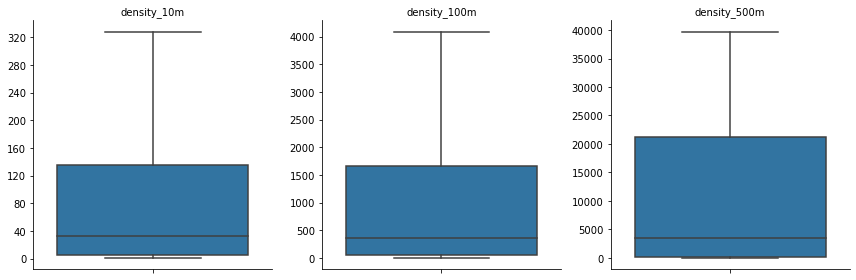

In [8]:
g=sns.FacetGrid(dens_long_df, col='density_scale', sharey=False, height=4)
g.map_dataframe(sns.boxplot, y="density",showfliers=False)
g.set_titles(col_template="{col_name}")
for ax in g.axes.flat:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))

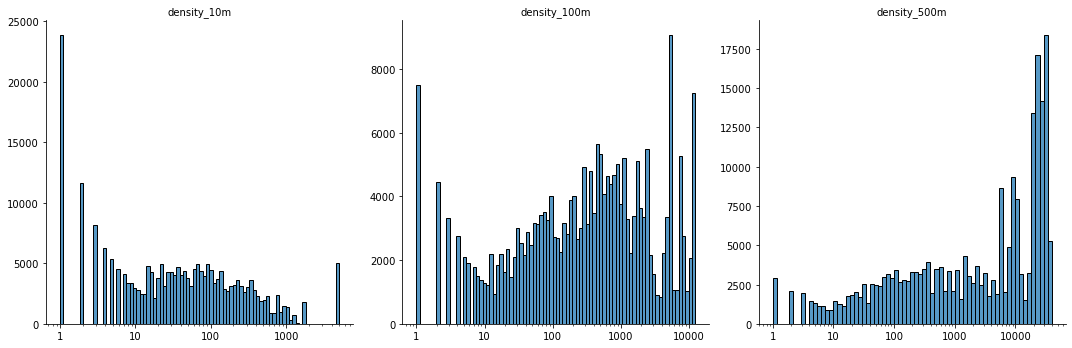

In [11]:
g=sns.FacetGrid(dens_long_df, col='density_scale', sharex=False,sharey=False, height=5)
g.map_dataframe(sns.histplot, x="density",kind=True)
g.set_titles(col_template="{col_name}")
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())

# Dataset splits

In [20]:
datasets=open_file('../resources/datasets.json')

In [21]:
print({k:len(v) for k,v in datasets.items()})

{'train': 219342, 'train_q': 6936, 'test_q': 2314, 'val_q': 2291}


In [28]:
from tqdm.notebook import tqdm
from dataclasses import make_dataclass
Record = make_dataclass("Record", [("ds_name", str), ("region", str), ("city_part", str)])

geo = []
for ds_name, ds_ids in tqdm(datasets.items(), desc='Iterating over datasets'):
    for photo_id in tqdm(ds_ids, desc=f'Iterating over {ds_name} dataset'):
        photo = FlickrPhoto.objects(photo_id=photo_id).first()
        geo.append(Record(ds_name, photo.geo.region, photo.geo.city_part))

Iterating over datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Iterating over train dataset:   0%|          | 0/219342 [00:00<?, ?it/s]

Iterating over train_q dataset:   0%|          | 0/6936 [00:00<?, ?it/s]

Iterating over test_q dataset:   0%|          | 0/2314 [00:00<?, ?it/s]

Iterating over val_q dataset:   0%|          | 0/2291 [00:00<?, ?it/s]

In [71]:
datasets_geo_df = pd.DataFrame(geo)

In [70]:
by_regions = datasets_geo_df.value_counts(['ds_name', 'region']).reset_index(name='count')

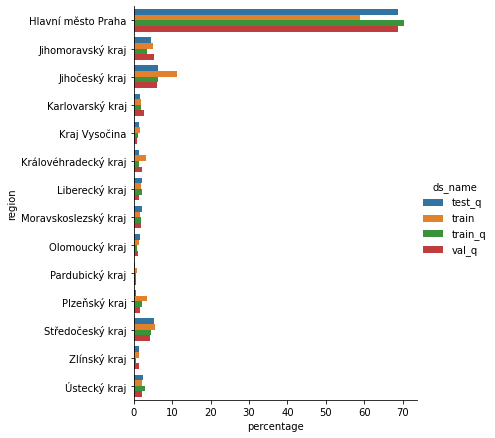

In [69]:
tmp = by_regions.groupby(['ds_name', 'region']).agg({'count': sum}).groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum())).reset_index()
tmp.rename(columns={'count': 'percentage'}, inplace=True)
sns.catplot(data=tmp, hue='ds_name', x='percentage', y='region', kind='bar', height=6)

In [96]:
dens_long_df['ds_name'] = pd.Series([None]*len(dens_long_df))
for k in datasets.keys():
    dens_long_df.loc[dens_long_df['photo_id'].isin(datasets[k]), 'ds_name']=k

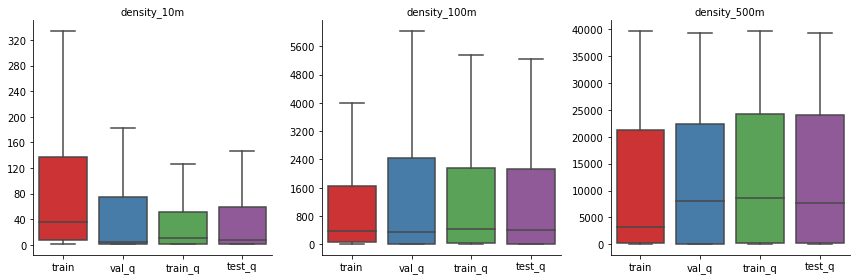

In [95]:
g=sns.FacetGrid(dens_long_df, col='density_scale', sharey=False, height=4)
g.map_dataframe(sns.boxplot, y="density",x='ds_name',showfliers=False, palette='Set1')
g.set_titles(col_template="{col_name}")
for ax in g.axes.flat:
    ax.yaxis.set_major_locator(ticker.MaxNLocator(10))